In [20]:
import os  # Used to check if file already exists
import pandas as pd  # Used to load and manipulate the ratings data
import zipfile  # Used to extract the contents of the zip file
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lime.lime_tabular import LimeTabularExplainer

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'  # URL for dataset
filename = 'ml-latest-small.zip'  # Name of zip file

if not os.path.exists(filename):  # Check if zip file exists
    !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip  # Download dataset if it doesn't exist

with zipfile.ZipFile(filename, 'r') as zip_ref:  # Extract the contents of the zip file
    zip_ref.extractall()

ratings = pd.read_csv('ml-latest-small/ratings.csv')  # Load ratings data
ratings.drop_duplicates(inplace=True)  # Remove duplicates
ratings.dropna(inplace=True)  # Remove missing values

user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)  # Convert data to user-item matrix

from sklearn.decomposition import TruncatedSVD  # Import matrix factorization method

svd = TruncatedSVD(n_components=100)  # Initialize matrix factorization
user_factors = svd.fit_transform(user_item_matrix)  # Generate user factors
item_factors = svd.components_  # Generate item factors

from sklearn.model_selection import train_test_split  # Import train-test split method

train_data, test_data = train_test_split(ratings, test_size=0.2)  # Split data into training and test sets
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)  # Convert training data to user-item matrix

svd = TruncatedSVD(n_components=100)  # Initialize matrix factorization
user_factors = svd.fit_transform(train_matrix)  # Generate user factors
item_factors = svd.components_  # Generate item factors

test_matrix = test_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)  # Convert test data to user-item matrix

predicted_ratings = user_factors.dot(item_factors)  # Predict ratings for test set

from sklearn.metrics import mean_squared_error, classification_report  # Import evaluation metrics

test_array = np.array(test_matrix)  # Convert test data to numpy array
predicted_ratings = user_factors.dot(item_factors)  # Predict ratings for test set

mse = mean_squared_error(predicted_ratings[test_array.nonzero()], test_array[test_array.nonzero()])  # Calculate MSE
print(f'Mean Squared Error: {mse}')

threshold = 3.5  # Set threshold for considering a prediction to be correct

predicted_binary = (predicted_ratings > threshold).astype(int)  # Convert predicted ratings to binary values
actual_binary = (test_array > threshold).astype(int)  # Convert actual ratings to binary values

report = classification_report(actual_binary[test_array.nonzero()], predicted_binary[test_array.nonzero()])  # Calculate precision, recall, and F1-score
print(f'Classification Report:\n{report}')  # Print evaluation metrics


Mean Squared Error: 12.266804303182676
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.97      0.67     10399
           1       0.47      0.03      0.06      9769

    accuracy                           0.51     20168
   macro avg       0.49      0.50      0.37     20168
weighted avg       0.49      0.51      0.38     20168



In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lime.lime_tabular import LimeTabularExplainer

# Perform matrix factorization using TruncatedSVD
svd = TruncatedSVD(n_components=100)
model = make_pipeline(StandardScaler(), svd, LinearRegression())

# Choose a random user and movie
user_id = 100
movie_id = 300

# Check if the movie_id variable is present in the user_item_matrix dataframe
if movie_id not in user_item_matrix.columns:
    print('Invalid movie ID. Please choose a different movie ID.')
else:
    # Specify the target variable y
    y = user_item_matrix[movie_id]

    # Remove the target variable from the feature matrix X
    X = user_item_matrix.drop(columns=movie_id)

    # Fit the linear regression model
    model.fit(X, y)

    # Make a prediction for the user and movie
    rating = model.predict(np.array([X.loc[user_id].values]))[0]

    # Generate an explanation for the recommendation using LIME
    explainer = LimeTabularExplainer(X.values, feature_names=X.columns, class_names=['rating'], verbose=True, mode='regression')
    explanation = explainer.explain_instance(X.loc[user_id].values, model.predict, num_features=10)


    # Print the prediction and explanation
    print(f'Prediction: {rating:.2f}')
    print('Explanation:')
    for feature, weight in explanation.as_list():
        print(f'{feature}: {weight:.2f}')

Intercept 1.9473861286876644
Prediction_local [0.45272241]
Right: 0.8233891315623197
Prediction: 0.82
Explanation:
55 <= 0.00: -0.28
287 <= 0.00: -0.25
726 <= 0.00: -0.21
722 <= 0.00: -0.21
214 <= 0.00: -0.15
452 <= 0.00: -0.12
580 <= 0.00: -0.09
1177 <= 0.00: -0.08
1280 <= 0.00: -0.06
305 <= 0.00: -0.06


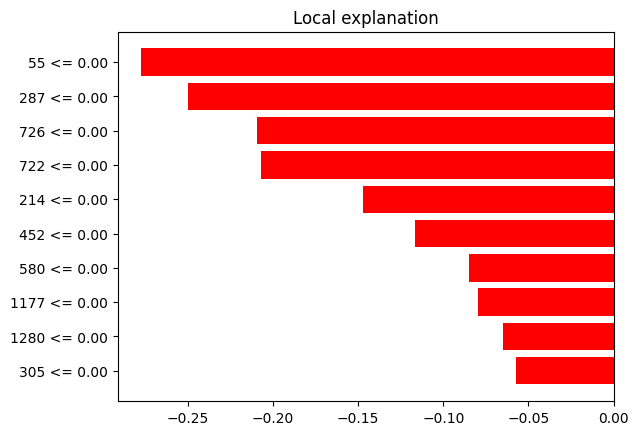

Top features for user 100 and movie 300:
55 <= 0.00: -0.2774217274517475
287 <= 0.00: -0.25009116473728515
726 <= 0.00: -0.20955530558970648
722 <= 0.00: -0.20700786928909257
214 <= 0.00: -0.14703923585600123
452 <= 0.00: -0.11679985442966898
580 <= 0.00: -0.08520456489750923
1177 <= 0.00: -0.0795670982342044
1280 <= 0.00: -0.06484717921313496
305 <= 0.00: -0.05712972126824353
Recommended movies for user 100 based on analyzed features:


In [19]:
import matplotlib.pyplot as plt

# Visualize the explanation using Matplotlib
fig = explanation.as_pyplot_figure()
plt.show()

top_features = explanation.as_list()
print(f'Top features for user {user_id} and movie {movie_id}:')
for feature, weight in top_features:
    print(f'{feature}: {weight}')

# Provide recommendations based on the analyzed features
recommended_movies = []
for feature, weight in top_features:
    if weight > 0:
        recommended_movies.extend(X[X[feature] > 0].index.tolist())
recommended_movies = list(set(recommended_movies))
print(f'Recommended movies for user {user_id} based on analyzed features:')
for movie in recommended_movies:
    if movie != movie_id:
        print(f'{movie}')